# Импорт библиотек

In [32]:
from IPython.display import clear_output
!pip install lightgbm==3.0
!pip install gdown
!pip install optuna
!pip install catboost
!pip install pytorch-tabnet
!pip install -U imbalanced-learn
clear_output()

In [33]:
import catboost
import itertools 
import imblearn
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import sklearn.datasets
import xgboost

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef
from pytorch_tabnet.tab_model import  TabNetRegressor

# Задание 1. Decision Tree Regressor

В данном задании мы посмотрим на результат применения [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) для сгенеренного набора данных.

Генерация данных:

In [34]:
np.random.seed(42)
m = 200
x = np.random.rand(m, 1) * 3 - 1
y = 4 * (x - 0.5) ** 3
y = y + np.random.randn(m, 1) / 10

Функция для визуализации результата:

In [35]:
def plot_regression_predictions(tree_reg, x, y, max_depth, x_range = [0, 1], 
                                y_range = [-1, 1]):
    """
    Visualize data and model predictions
    :param tree_reg: trained model,
    :param x: features
    :param y: true values
    :param max_depth: max tree depth
    :param x_range: x range
    :param y_range: y range
    """
    x_pred = np.linspace(x_range[0], x_range[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x_pred)

    plt.xlim(x_range)
    plt.ylim(y_range)

    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$y$", fontsize=18, rotation=0)
    
    plt.plot(x, y, "b.", label="data")
    plt.plot(x_pred, y_pred, "r.-", linewidth=2, label=f"max_depth = {max_depth}")
    plt.legend()

Глянем результат работы [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) при изменении глубины дерева (`random_state=42`). В качестве значений глубины использую $2, 5, 6, 9, 12, 15$.
Визуализирую на тех же данных, на которых происходило обучение.


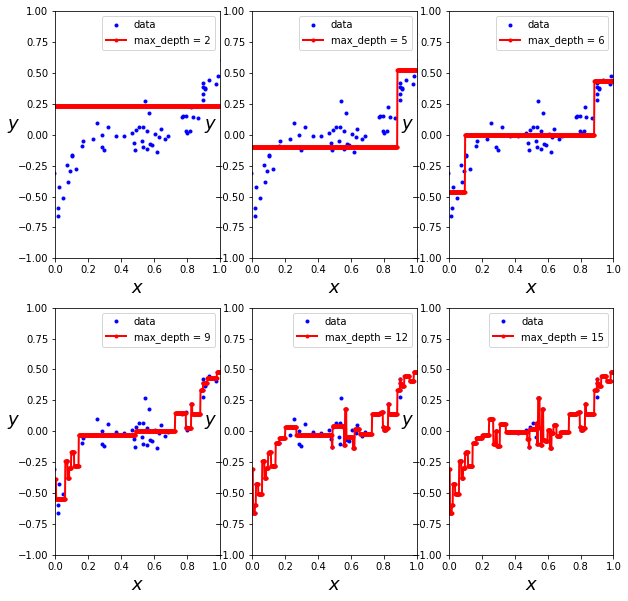

In [36]:
from sklearn.tree import DecisionTreeRegressor

plt.figure(figsize=(10,10))

j=1
for t in [2,5,6,9,12,15]:
    tr_reg=DecisionTreeRegressor(max_depth=t, random_state=42)
    tr_reg.fit(x, y)
    ax = plt.subplot(2, 3, j)
    plot_regression_predictions(tr_reg, x, y, max_depth=t, x_range = [0, 1], y_range = [-1, 1])
    j+=1



При увеличении глубины дерева bias уменьшается, но variance растет - при большой глубине наша модель прямо дико переобученная. 

# Задание 2. Bootstrap

В этом задании будем использовать классический датасет для задачи бинарной классификации -- breast_cancer &mdash;. Обучим модели:

 - `DecisionTreeClassifier`
 -`RandomForestClassifier` 
 -`LigthGBMClassifier` 
 -`SVC` 
 -`BaggingClassifier` с базовым класификатором - SVC . 


Для каждой модели посчитаем [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) &mdash; метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), [доп.](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) для предсказанного ею класса и реального 

С помощью bootstrap-подхода построим 90% доверительные интервалы для качества полученных моделей. Будем юзать функцию `bootstrap_metric`.

Наконец, построим [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей

In [37]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [38]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Matthews corr for Dec.Tr.:  [0.83276158 0.95594834]
Matthews corr for Rand.For.:  [0.88953352 0.98517822]
Matthews corr for LGB:  [0.82950665 0.95459809]
Matthews corr for SVC:  [0.83030554 0.95532067]
Matthews corr for Bagging:  [0.83030554 0.95532067]


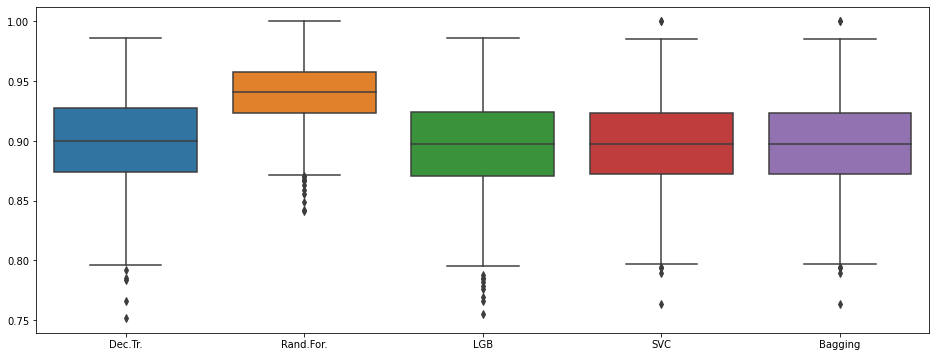

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

import pandas as pd


def bootstrap_metric(x, 
                     y,
                     metric_fn,
                     samples_cnt=1000,
                     random_state=42):
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric




tr_cl=DecisionTreeClassifier()
rf_cl=RandomForestClassifier()
lgb_cl = lgb.LGBMClassifier()
svc_cl=SVC()
bag_cl=BaggingClassifier(base_estimator=SVC())

tr_cl.fit(x_train, y_train)
rf_cl.fit(x_train, y_train)
lgb_cl.fit(x_train, y_train)
svc_cl.fit(x_train, y_train)
bag_cl.fit(x_train, y_train)

#
m1_corr = bootstrap_metric(y_test, tr_cl.predict(x_test), metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))
m2_corr = bootstrap_metric(y_test, rf_cl.predict(x_test), metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))
m3_corr = bootstrap_metric(y_test, lgb_cl.predict(x_test), metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))
m4_corr = bootstrap_metric(y_test, svc_cl.predict(x_test), metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))
m5_corr = bootstrap_metric(y_test, bag_cl.predict(x_test), metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))

# строим доверительные интервалы:
alpha = 0.10
print("Matthews corr for Dec.Tr.: ", np.quantile(m1_corr, q=[alpha/2, 1 - alpha/2]))
print("Matthews corr for Rand.For.: ", np.quantile(m2_corr, q=[alpha/2, 1 - alpha/2]))
print("Matthews corr for LGB: ", np.quantile(m3_corr, q=[alpha/2, 1 - alpha/2]))
print("Matthews corr for SVC: ", np.quantile(m4_corr, q=[alpha/2, 1 - alpha/2]))
print("Matthews corr for Bagging: ", np.quantile(m5_corr, q=[alpha/2, 1 - alpha/2]))

plt.figure(figsize=(16, 6))
sns.boxplot(y=np.concatenate([m1_corr, m2_corr, m3_corr, m4_corr, m5_corr]),
            x=["Dec.Tr."] * 1000 + ['Rand.For.'] * 1000 + ['LGB'] * 1000 + ['SVC'] * 1000 + ['Bagging'] * 1000);

#

#df=pd.DataFrame([a,b,c,d,e], index =['Dec.Tr.', 'Rand.For.', 'LGB', 'SVC', 'Bagging'],columns =['Matthews corr.']).T

#plt.figure(figsize=(16, 6))
#sns.boxplot(data=df);


# Задание 3. Обучение и подбор параметров

Загрузим датасет с рецептами (состав блюд и дополнительные данные о них) и рейтингом рецептов.

In [40]:
recipies = pd.read_csv("https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX03/recipes.csv")
print(recipies.iloc[:, 0:5].head())

                                         title  rating  calories  protein  \
0              Lentil, Apple, and Turkey Wrap    2.500     426.0     30.0   
1  Boudin Blanc Terrine with Red Onion Confit    4.375     403.0     18.0   
2                Potato and Fennel Soup Hodge    3.750     165.0      6.0   
3             Mahi-Mahi in Tomato Olive Sauce    5.000       NaN      NaN   
4                    Spinach Noodle Casserole    3.125     547.0     20.0   

    fat  
0   7.0  
1  23.0  
2   7.0  
3   NaN  
4  32.0  


In [41]:
recipies = recipies.loc[pd.isna(recipies).sum(axis=1)==0, :] # remove na
y = recipies['rating']
x = recipies.drop(["rating", "title"], axis=1)
x_train_all, x_test, y_train_all, y_test = train_test_split(x.values, y.values, train_size=0.7, random_state=42)

Замутим модель, предсказывающую рейтинг рецепта по всем имеющимся признакам. Для анализа качества моделей возьмем метрику `MSE`.

В этой задачке нужно выбьрать 2 модели -- один случайный лес и один бустинг из приведенных ниже.

1. `xgboost.XGBRegressor`
2. `xgboost.XGBRFRegressor` (случайный лес от xgboost)
3. `lightgbm.LGBMRegressor`
4. `lightgbm.LGBMRegressor(boosting_type="rf")` (случайный лес от lightgbm)
5. `catboost.CatBoostRegressor`

Кроме этого, нужно использовать также 
`TabNetRegressor`.

Для первых двух моделей попробую оптимизировать их параметры, чтобы получить хорошее качество. 

Для TabNetRegressor попробую разные значения параметров `n_a` и `n_d`.

В конце сравним качество полученных моделей.

In [42]:
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

#rf=XGBRFRegressor()
#gb=LGBMRegressor()

#rf.fit(x_train_all, y_train_all)
#gb.fit(x_train_all, y_train_all)




Руками чуть поподбираем параметры для случайного леса.

In [43]:
from sklearn.metrics import mean_squared_error
import math

rf_best_par=[]
mse=[]
k=0
for i in range(3,20):
    rf_best_par.append(i*9)
    rf=XGBRFRegressor(n_estimators=rf_best_par[k]) 
    rf.fit(x_train_all, y_train_all)
    mse.append(mean_squared_error(y_test, rf.predict(x_test)))
    k+=1

min=math.inf
j=0
k=0
for i in range(3,12):
    if mse[k]<min:
        min=mse[k]
        j=k
    k+=1

print("Лучший параметр n_estimators для случайного леса:", rf_best_par[j])
print("MSE =",mse[j])



[09:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Теперь руками чуть поподбираем параметры для бустинга.

In [44]:

gb_best_par=[]
mse=[]
k=0
for i in range(3,20):
    gb_best_par.append(i*9)
    gb=LGBMRegressor(n_estimators=rf_best_par[k]) 
    gb.fit(x_train_all, y_train_all)
    mse.append(mean_squared_error(y_test, gb.predict(x_test)))
    k+=1

min=math.inf
j=0
k=0
for i in range(3,12):
    if mse[k]<min:
        min=mse[k]
        j=k
    k+=1

print("Лучший параметр n_estimators для градиентного бустинга:", rf_best_par[j])
print("MSE =",mse[j])


Лучший параметр n_estimators для градиентного бустинга: 90
MSE = 1.3748219674392692


Теперь руками подбираем параметры для TabNetRegressor.

In [45]:
y_train= y_train_all.reshape(-1,1) 

tb_best_par=[] # тут пары (n_a,n_d)
mse=[]
k=0
for i in range(7,12):
    for j in range(7,12):
        tb_best_par.append((i,j))
        tb=TabNetRegressor(n_a=i, n_d=j) 
        tb.fit(x_train_all, y_train, max_epochs=30)
        mse.append(mean_squared_error(y_test, tb.predict(x_test)))
        k+=1

min=math.inf

j=0
for i in range(len(mse)):
    if mse[i]<min:
        min=mse[i]
        j=i

print("Лучшие параметы (n_a, n_d) для TabNetRegressor:", tb_best_par[j])
print("MSE =",mse[j])


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.00923|  0:00:03s
epoch 1  | loss: 3.87034 |  0:00:06s
epoch 2  | loss: 2.20894 |  0:00:09s
epoch 3  | loss: 1.8348  |  0:00:12s
epoch 4  | loss: 1.73518 |  0:00:15s
epoch 5  | loss: 1.69985 |  0:00:17s
epoch 6  | loss: 1.70127 |  0:00:20s
epoch 7  | loss: 1.70077 |  0:00:23s
epoch 8  | loss: 1.6684  |  0:00:26s
epoch 9  | loss: 1.65802 |  0:00:29s
epoch 10 | loss: 1.65929 |  0:00:32s
epoch 11 | loss: 1.6586  |  0:00:35s
epoch 12 | loss: 1.63416 |  0:00:38s
epoch 13 | loss: 1.60361 |  0:00:41s
epoch 14 | loss: 1.60711 |  0:00:44s
epoch 15 | loss: 1.56103 |  0:00:47s
epoch 16 | loss: 1.54849 |  0:00:50s
epoch 17 | loss: 1.53533 |  0:00:53s
epoch 18 | loss: 1.49742 |  0:00:56s
epoch 19 | loss: 1.46447 |  0:00:59s
epoch 20 | loss: 1.46332 |  0:01:02s
epoch 21 | loss: 1.46216 |  0:01:05s
epoch 22 | loss: 1.4034  |  0:01:08s
epoch 23 | loss: 1.39618 |  0:01:11s
epoch 24 | loss: 1.3553  |  0:01:14s
epoch 25 | loss: 1.33599 |  0:01:17s
epoch 26 | loss: 1.3193  |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.82731 |  0:00:03s
epoch 1  | loss: 3.12214 |  0:00:06s
epoch 2  | loss: 2.07801 |  0:00:09s
epoch 3  | loss: 1.82931 |  0:00:12s
epoch 4  | loss: 1.72723 |  0:00:15s
epoch 5  | loss: 1.67351 |  0:00:18s
epoch 6  | loss: 1.63087 |  0:00:21s
epoch 7  | loss: 1.62418 |  0:00:24s
epoch 8  | loss: 1.59686 |  0:00:27s
epoch 9  | loss: 1.59315 |  0:00:30s
epoch 10 | loss: 1.5381  |  0:00:33s
epoch 11 | loss: 1.53128 |  0:00:36s
epoch 12 | loss: 1.47949 |  0:00:39s
epoch 13 | loss: 1.46393 |  0:00:42s
epoch 14 | loss: 1.45022 |  0:00:45s
epoch 15 | loss: 1.41839 |  0:00:48s
epoch 16 | loss: 1.37931 |  0:00:51s
epoch 17 | loss: 1.36888 |  0:00:54s
epoch 18 | loss: 1.33346 |  0:00:57s
epoch 19 | loss: 1.29538 |  0:01:00s
epoch 20 | loss: 1.27062 |  0:01:03s
epoch 21 | loss: 1.2142  |  0:01:06s
epoch 22 | loss: 1.18839 |  0:01:09s
epoch 23 | loss: 1.18372 |  0:01:12s
epoch 24 | loss: 1.14341 |  0:01:15s
epoch 25 | loss: 1.13463 |  0:01:18s
epoch 26 | loss: 1.11241 |  0:01:22s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.05934 |  0:00:02s
epoch 1  | loss: 2.7423  |  0:00:05s
epoch 2  | loss: 2.02151 |  0:00:08s
epoch 3  | loss: 1.8612  |  0:00:11s
epoch 4  | loss: 1.75126 |  0:00:14s
epoch 5  | loss: 1.74741 |  0:00:17s
epoch 6  | loss: 1.65738 |  0:00:20s
epoch 7  | loss: 1.61317 |  0:00:23s
epoch 8  | loss: 1.61343 |  0:00:26s
epoch 9  | loss: 1.6138  |  0:00:29s
epoch 10 | loss: 1.5986  |  0:00:32s
epoch 11 | loss: 1.57865 |  0:00:35s
epoch 12 | loss: 1.58297 |  0:00:38s
epoch 13 | loss: 1.55603 |  0:00:41s
epoch 14 | loss: 1.56272 |  0:00:44s
epoch 15 | loss: 1.54494 |  0:00:46s
epoch 16 | loss: 1.5197  |  0:00:49s
epoch 17 | loss: 1.52036 |  0:00:52s
epoch 18 | loss: 1.49265 |  0:00:55s
epoch 19 | loss: 1.48803 |  0:00:58s
epoch 20 | loss: 1.45734 |  0:01:01s
epoch 21 | loss: 1.42821 |  0:01:04s
epoch 22 | loss: 1.41266 |  0:01:07s
epoch 23 | loss: 1.39356 |  0:01:10s
epoch 24 | loss: 1.37453 |  0:01:13s
epoch 25 | loss: 1.34753 |  0:01:16s
epoch 26 | loss: 1.3225  |  0:01:19s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 17.80487|  0:00:03s
epoch 1  | loss: 9.10566 |  0:00:06s
epoch 2  | loss: 3.96795 |  0:00:08s
epoch 3  | loss: 2.40822 |  0:00:12s
epoch 4  | loss: 1.90406 |  0:00:15s
epoch 5  | loss: 1.73641 |  0:00:18s
epoch 6  | loss: 1.72362 |  0:00:21s
epoch 7  | loss: 1.69636 |  0:00:24s
epoch 8  | loss: 1.69879 |  0:00:27s
epoch 9  | loss: 1.68514 |  0:00:30s
epoch 10 | loss: 1.68524 |  0:00:33s
epoch 11 | loss: 1.62959 |  0:00:36s
epoch 12 | loss: 1.62913 |  0:00:39s
epoch 13 | loss: 1.62908 |  0:00:42s
epoch 14 | loss: 1.62734 |  0:00:45s
epoch 15 | loss: 1.59158 |  0:00:48s
epoch 16 | loss: 1.56862 |  0:00:51s
epoch 17 | loss: 1.55863 |  0:00:54s
epoch 18 | loss: 1.55964 |  0:00:57s
epoch 19 | loss: 1.53557 |  0:01:00s
epoch 20 | loss: 1.49854 |  0:01:03s
epoch 21 | loss: 1.49178 |  0:01:06s
epoch 22 | loss: 1.46427 |  0:01:09s
epoch 23 | loss: 1.43677 |  0:01:12s
epoch 24 | loss: 1.4002  |  0:01:15s
epoch 25 | loss: 1.43543 |  0:01:18s
epoch 26 | loss: 1.40463 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.45273|  0:00:03s
epoch 1  | loss: 4.45994 |  0:00:06s
epoch 2  | loss: 2.58018 |  0:00:09s
epoch 3  | loss: 1.87031 |  0:00:12s
epoch 4  | loss: 1.75137 |  0:00:15s
epoch 5  | loss: 1.72515 |  0:00:18s
epoch 6  | loss: 1.68315 |  0:00:21s
epoch 7  | loss: 1.68149 |  0:00:24s
epoch 8  | loss: 1.69283 |  0:00:27s
epoch 9  | loss: 1.64729 |  0:00:30s
epoch 10 | loss: 1.62755 |  0:00:33s
epoch 11 | loss: 1.62188 |  0:00:36s
epoch 12 | loss: 1.59301 |  0:00:39s
epoch 13 | loss: 1.56322 |  0:00:42s
epoch 14 | loss: 1.50154 |  0:00:45s
epoch 15 | loss: 1.4922  |  0:00:49s
epoch 16 | loss: 1.48369 |  0:00:52s
epoch 17 | loss: 1.43147 |  0:00:55s
epoch 18 | loss: 1.42598 |  0:00:58s
epoch 19 | loss: 1.39718 |  0:01:01s
epoch 20 | loss: 1.35032 |  0:01:04s
epoch 21 | loss: 1.33564 |  0:01:07s
epoch 22 | loss: 1.3027  |  0:01:10s
epoch 23 | loss: 1.26596 |  0:01:13s
epoch 24 | loss: 1.27078 |  0:01:16s
epoch 25 | loss: 1.22883 |  0:01:19s
epoch 26 | loss: 1.19573 |  0:01:22s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 13.87253|  0:00:03s
epoch 1  | loss: 5.97689 |  0:00:06s
epoch 2  | loss: 2.92255 |  0:00:09s
epoch 3  | loss: 2.08541 |  0:00:12s
epoch 4  | loss: 1.88813 |  0:00:15s
epoch 5  | loss: 1.71091 |  0:00:18s
epoch 6  | loss: 1.65387 |  0:00:21s
epoch 7  | loss: 1.6394  |  0:00:24s
epoch 8  | loss: 1.64192 |  0:00:27s
epoch 9  | loss: 1.60401 |  0:00:30s
epoch 10 | loss: 1.65136 |  0:00:33s
epoch 11 | loss: 1.57529 |  0:00:36s
epoch 12 | loss: 1.58613 |  0:00:39s
epoch 13 | loss: 1.56001 |  0:00:42s
epoch 14 | loss: 1.54444 |  0:00:45s
epoch 15 | loss: 1.53406 |  0:00:48s
epoch 16 | loss: 1.54949 |  0:00:51s
epoch 17 | loss: 1.53884 |  0:00:54s
epoch 18 | loss: 1.51531 |  0:00:57s
epoch 19 | loss: 1.48881 |  0:01:00s
epoch 20 | loss: 1.53427 |  0:01:03s
epoch 21 | loss: 1.52756 |  0:01:06s
epoch 22 | loss: 1.49607 |  0:01:09s
epoch 23 | loss: 1.47204 |  0:01:12s
epoch 24 | loss: 1.45428 |  0:01:15s
epoch 25 | loss: 1.43003 |  0:01:18s
epoch 26 | loss: 1.42648 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 11.01697|  0:00:03s
epoch 1  | loss: 3.91445 |  0:00:06s
epoch 2  | loss: 2.30991 |  0:00:10s
epoch 3  | loss: 1.87637 |  0:00:13s
epoch 4  | loss: 1.73923 |  0:00:16s
epoch 5  | loss: 1.69883 |  0:00:19s
epoch 6  | loss: 1.65252 |  0:00:22s
epoch 7  | loss: 1.66498 |  0:00:25s
epoch 8  | loss: 1.65089 |  0:00:28s
epoch 9  | loss: 1.6207  |  0:00:31s
epoch 10 | loss: 1.64408 |  0:00:34s
epoch 11 | loss: 1.59785 |  0:00:37s
epoch 12 | loss: 1.59676 |  0:00:40s
epoch 13 | loss: 1.62342 |  0:00:42s
epoch 14 | loss: 1.58802 |  0:00:45s
epoch 15 | loss: 1.56998 |  0:00:48s
epoch 16 | loss: 1.58324 |  0:00:51s
epoch 17 | loss: 1.5887  |  0:00:54s
epoch 18 | loss: 1.57704 |  0:00:57s
epoch 19 | loss: 1.54259 |  0:01:00s
epoch 20 | loss: 1.56489 |  0:01:03s
epoch 21 | loss: 1.55879 |  0:01:06s
epoch 22 | loss: 1.50371 |  0:01:09s
epoch 23 | loss: 1.4836  |  0:01:12s
epoch 24 | loss: 1.47763 |  0:01:15s
epoch 25 | loss: 1.45591 |  0:01:18s
epoch 26 | loss: 1.42817 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 13.58076|  0:00:02s
epoch 1  | loss: 5.6216  |  0:00:05s
epoch 2  | loss: 2.75539 |  0:00:08s
epoch 3  | loss: 2.09382 |  0:00:11s
epoch 4  | loss: 1.84669 |  0:00:14s
epoch 5  | loss: 1.73079 |  0:00:17s
epoch 6  | loss: 1.70888 |  0:00:20s
epoch 7  | loss: 1.6974  |  0:00:23s
epoch 8  | loss: 1.64147 |  0:00:26s
epoch 9  | loss: 1.63981 |  0:00:29s
epoch 10 | loss: 1.58556 |  0:00:32s
epoch 11 | loss: 1.61152 |  0:00:35s
epoch 12 | loss: 1.57702 |  0:00:38s
epoch 13 | loss: 1.53549 |  0:00:41s
epoch 14 | loss: 1.53695 |  0:00:44s
epoch 15 | loss: 1.45758 |  0:00:47s
epoch 16 | loss: 1.4361  |  0:00:50s
epoch 17 | loss: 1.42747 |  0:00:53s
epoch 18 | loss: 1.39521 |  0:00:57s
epoch 19 | loss: 1.38529 |  0:01:00s
epoch 20 | loss: 1.36369 |  0:01:03s
epoch 21 | loss: 1.34671 |  0:01:06s
epoch 22 | loss: 1.31207 |  0:01:09s
epoch 23 | loss: 1.28722 |  0:01:12s
epoch 24 | loss: 1.26123 |  0:01:15s
epoch 25 | loss: 1.26728 |  0:01:18s
epoch 26 | loss: 1.24443 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.47695|  0:00:03s
epoch 1  | loss: 4.17152 |  0:00:06s
epoch 2  | loss: 2.23328 |  0:00:09s
epoch 3  | loss: 1.86054 |  0:00:12s
epoch 4  | loss: 1.77055 |  0:00:15s
epoch 5  | loss: 1.73622 |  0:00:18s
epoch 6  | loss: 1.68285 |  0:00:21s
epoch 7  | loss: 1.65167 |  0:00:24s
epoch 8  | loss: 1.6512  |  0:00:27s
epoch 9  | loss: 1.59938 |  0:00:29s
epoch 10 | loss: 1.62752 |  0:00:32s
epoch 11 | loss: 1.63729 |  0:00:35s
epoch 12 | loss: 1.59773 |  0:00:38s
epoch 13 | loss: 1.60497 |  0:00:41s
epoch 14 | loss: 1.57615 |  0:00:44s
epoch 15 | loss: 1.59495 |  0:00:47s
epoch 16 | loss: 1.56401 |  0:00:50s
epoch 17 | loss: 1.59956 |  0:00:53s
epoch 18 | loss: 1.57479 |  0:00:56s
epoch 19 | loss: 1.59914 |  0:00:59s
epoch 20 | loss: 1.57857 |  0:01:02s
epoch 21 | loss: 1.57624 |  0:01:05s
epoch 22 | loss: 1.56686 |  0:01:08s
epoch 23 | loss: 1.55333 |  0:01:11s
epoch 24 | loss: 1.52065 |  0:01:14s
epoch 25 | loss: 1.56231 |  0:01:17s
epoch 26 | loss: 1.52637 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.95683|  0:00:03s
epoch 1  | loss: 4.00592 |  0:00:06s
epoch 2  | loss: 2.10056 |  0:00:09s
epoch 3  | loss: 1.78583 |  0:00:12s
epoch 4  | loss: 1.7135  |  0:00:15s
epoch 5  | loss: 1.6713  |  0:00:18s
epoch 6  | loss: 1.66505 |  0:00:22s
epoch 7  | loss: 1.63541 |  0:00:25s
epoch 8  | loss: 1.60498 |  0:00:28s
epoch 9  | loss: 1.59211 |  0:00:31s
epoch 10 | loss: 1.63065 |  0:00:34s
epoch 11 | loss: 1.62506 |  0:00:37s
epoch 12 | loss: 1.58964 |  0:00:40s
epoch 13 | loss: 1.59242 |  0:00:43s
epoch 14 | loss: 1.57602 |  0:00:45s
epoch 15 | loss: 1.57627 |  0:00:48s
epoch 16 | loss: 1.5615  |  0:00:51s
epoch 17 | loss: 1.54055 |  0:00:54s
epoch 18 | loss: 1.52695 |  0:00:57s
epoch 19 | loss: 1.51702 |  0:01:00s
epoch 20 | loss: 1.48631 |  0:01:03s
epoch 21 | loss: 1.50051 |  0:01:06s
epoch 22 | loss: 1.48304 |  0:01:09s
epoch 23 | loss: 1.46064 |  0:01:12s
epoch 24 | loss: 1.44728 |  0:01:15s
epoch 25 | loss: 1.4262  |  0:01:18s
epoch 26 | loss: 1.38548 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.16453|  0:00:02s
epoch 1  | loss: 3.60972 |  0:00:05s
epoch 2  | loss: 2.30533 |  0:00:08s
epoch 3  | loss: 1.91213 |  0:00:11s
epoch 4  | loss: 1.82327 |  0:00:14s
epoch 5  | loss: 1.75547 |  0:00:17s
epoch 6  | loss: 1.71393 |  0:00:20s
epoch 7  | loss: 1.67989 |  0:00:23s
epoch 8  | loss: 1.66977 |  0:00:26s
epoch 9  | loss: 1.66018 |  0:00:29s
epoch 10 | loss: 1.64247 |  0:00:32s
epoch 11 | loss: 1.62711 |  0:00:35s
epoch 12 | loss: 1.65909 |  0:00:38s
epoch 13 | loss: 1.63875 |  0:00:41s
epoch 14 | loss: 1.60486 |  0:00:44s
epoch 15 | loss: 1.61384 |  0:00:47s
epoch 16 | loss: 1.62326 |  0:00:50s
epoch 17 | loss: 1.6276  |  0:00:53s
epoch 18 | loss: 1.62531 |  0:00:55s
epoch 19 | loss: 1.59164 |  0:00:58s
epoch 20 | loss: 1.584   |  0:01:01s
epoch 21 | loss: 1.60718 |  0:01:04s
epoch 22 | loss: 1.59556 |  0:01:08s
epoch 23 | loss: 1.59048 |  0:01:11s
epoch 24 | loss: 1.58937 |  0:01:14s
epoch 25 | loss: 1.57289 |  0:01:17s
epoch 26 | loss: 1.54894 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.26684 |  0:00:02s
epoch 1  | loss: 3.75673 |  0:00:05s
epoch 2  | loss: 2.13763 |  0:00:08s
epoch 3  | loss: 1.85728 |  0:00:11s
epoch 4  | loss: 1.7804  |  0:00:14s
epoch 5  | loss: 1.69309 |  0:00:17s
epoch 6  | loss: 1.66167 |  0:00:20s
epoch 7  | loss: 1.66392 |  0:00:23s
epoch 8  | loss: 1.6169  |  0:00:26s
epoch 9  | loss: 1.63923 |  0:00:29s
epoch 10 | loss: 1.59162 |  0:00:32s
epoch 11 | loss: 1.60942 |  0:00:35s
epoch 12 | loss: 1.6253  |  0:00:38s
epoch 13 | loss: 1.59327 |  0:00:41s
epoch 14 | loss: 1.56628 |  0:00:44s
epoch 15 | loss: 1.54004 |  0:00:47s
epoch 16 | loss: 1.55161 |  0:00:51s
epoch 17 | loss: 1.52726 |  0:00:54s
epoch 18 | loss: 1.5281  |  0:00:56s
epoch 19 | loss: 1.50965 |  0:01:00s
epoch 20 | loss: 1.51986 |  0:01:03s
epoch 21 | loss: 1.47012 |  0:01:05s
epoch 22 | loss: 1.46225 |  0:01:08s
epoch 23 | loss: 1.45305 |  0:01:11s
epoch 24 | loss: 1.46055 |  0:01:15s
epoch 25 | loss: 1.43688 |  0:01:17s
epoch 26 | loss: 1.46227 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 18.03395|  0:00:02s
epoch 1  | loss: 9.30201 |  0:00:05s
epoch 2  | loss: 3.66837 |  0:00:08s
epoch 3  | loss: 2.33149 |  0:00:11s
epoch 4  | loss: 1.92586 |  0:00:14s
epoch 5  | loss: 1.80942 |  0:00:17s
epoch 6  | loss: 1.70966 |  0:00:20s
epoch 7  | loss: 1.70993 |  0:00:23s
epoch 8  | loss: 1.68071 |  0:00:27s
epoch 9  | loss: 1.67539 |  0:00:30s
epoch 10 | loss: 1.67499 |  0:00:33s
epoch 11 | loss: 1.63562 |  0:00:36s
epoch 12 | loss: 1.63589 |  0:00:39s
epoch 13 | loss: 1.61069 |  0:00:42s
epoch 14 | loss: 1.58234 |  0:00:45s
epoch 15 | loss: 1.60385 |  0:00:48s
epoch 16 | loss: 1.59768 |  0:00:51s
epoch 17 | loss: 1.58585 |  0:00:54s
epoch 18 | loss: 1.57184 |  0:00:57s
epoch 19 | loss: 1.5907  |  0:01:00s
epoch 20 | loss: 1.56995 |  0:01:03s
epoch 21 | loss: 1.52634 |  0:01:06s
epoch 22 | loss: 1.55838 |  0:01:09s
epoch 23 | loss: 1.54514 |  0:01:12s
epoch 24 | loss: 1.52055 |  0:01:15s
epoch 25 | loss: 1.53019 |  0:01:18s
epoch 26 | loss: 1.50352 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.57616 |  0:00:03s
epoch 1  | loss: 3.61144 |  0:00:06s
epoch 2  | loss: 2.22579 |  0:00:09s
epoch 3  | loss: 1.96163 |  0:00:12s
epoch 4  | loss: 1.80525 |  0:00:15s
epoch 5  | loss: 1.73703 |  0:00:18s
epoch 6  | loss: 1.68873 |  0:00:21s
epoch 7  | loss: 1.68397 |  0:00:24s
epoch 8  | loss: 1.6702  |  0:00:27s
epoch 9  | loss: 1.6356  |  0:00:30s
epoch 10 | loss: 1.63692 |  0:00:33s
epoch 11 | loss: 1.6196  |  0:00:36s
epoch 12 | loss: 1.63152 |  0:00:39s
epoch 13 | loss: 1.64092 |  0:00:42s
epoch 14 | loss: 1.61824 |  0:00:45s
epoch 15 | loss: 1.5898  |  0:00:48s
epoch 16 | loss: 1.60122 |  0:00:51s
epoch 17 | loss: 1.58584 |  0:00:54s
epoch 18 | loss: 1.56595 |  0:00:57s
epoch 19 | loss: 1.5548  |  0:01:00s
epoch 20 | loss: 1.54036 |  0:01:03s
epoch 21 | loss: 1.49069 |  0:01:06s
epoch 22 | loss: 1.46513 |  0:01:09s
epoch 23 | loss: 1.44004 |  0:01:12s
epoch 24 | loss: 1.4197  |  0:01:15s
epoch 25 | loss: 1.37816 |  0:01:18s
epoch 26 | loss: 1.34907 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.17685|  0:00:02s
epoch 1  | loss: 4.08675 |  0:00:05s
epoch 2  | loss: 2.2237  |  0:00:09s
epoch 3  | loss: 1.89332 |  0:00:12s
epoch 4  | loss: 1.79038 |  0:00:15s
epoch 5  | loss: 1.70938 |  0:00:17s
epoch 6  | loss: 1.69852 |  0:00:20s
epoch 7  | loss: 1.67961 |  0:00:23s
epoch 8  | loss: 1.68245 |  0:00:26s
epoch 9  | loss: 1.65583 |  0:00:29s
epoch 10 | loss: 1.66223 |  0:00:32s
epoch 11 | loss: 1.60168 |  0:00:35s
epoch 12 | loss: 1.56219 |  0:00:38s
epoch 13 | loss: 1.54006 |  0:00:41s
epoch 14 | loss: 1.48964 |  0:00:44s
epoch 15 | loss: 1.46474 |  0:00:47s
epoch 16 | loss: 1.45264 |  0:00:50s
epoch 17 | loss: 1.40331 |  0:00:53s
epoch 18 | loss: 1.3953  |  0:00:56s
epoch 19 | loss: 1.36827 |  0:00:59s
epoch 20 | loss: 1.33787 |  0:01:02s
epoch 21 | loss: 1.32949 |  0:01:05s
epoch 22 | loss: 1.2849  |  0:01:08s
epoch 23 | loss: 1.30497 |  0:01:11s
epoch 24 | loss: 1.28572 |  0:01:13s
epoch 25 | loss: 1.24674 |  0:01:16s
epoch 26 | loss: 1.22973 |  0:01:19s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 16.29931|  0:00:02s
epoch 1  | loss: 6.68769 |  0:00:05s
epoch 2  | loss: 2.88319 |  0:00:08s
epoch 3  | loss: 2.11105 |  0:00:11s
epoch 4  | loss: 1.85551 |  0:00:14s
epoch 5  | loss: 1.72942 |  0:00:17s
epoch 6  | loss: 1.71067 |  0:00:20s
epoch 7  | loss: 1.69495 |  0:00:23s
epoch 8  | loss: 1.66269 |  0:00:26s
epoch 9  | loss: 1.63842 |  0:00:29s
epoch 10 | loss: 1.60908 |  0:00:32s
epoch 11 | loss: 1.59158 |  0:00:35s
epoch 12 | loss: 1.55912 |  0:00:38s
epoch 13 | loss: 1.57782 |  0:00:41s
epoch 14 | loss: 1.52148 |  0:00:45s
epoch 15 | loss: 1.52705 |  0:00:48s
epoch 16 | loss: 1.50299 |  0:00:51s
epoch 17 | loss: 1.46132 |  0:00:54s
epoch 18 | loss: 1.4315  |  0:00:57s
epoch 19 | loss: 1.40052 |  0:01:00s
epoch 20 | loss: 1.41422 |  0:01:02s
epoch 21 | loss: 1.38222 |  0:01:05s
epoch 22 | loss: 1.35621 |  0:01:08s
epoch 23 | loss: 1.33137 |  0:01:11s
epoch 24 | loss: 1.29255 |  0:01:14s
epoch 25 | loss: 1.30013 |  0:01:17s
epoch 26 | loss: 1.27249 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.95873 |  0:00:02s
epoch 1  | loss: 3.45706 |  0:00:06s
epoch 2  | loss: 2.20336 |  0:00:08s
epoch 3  | loss: 1.9428  |  0:00:11s
epoch 4  | loss: 1.79553 |  0:00:14s
epoch 5  | loss: 1.75393 |  0:00:17s
epoch 6  | loss: 1.7028  |  0:00:20s
epoch 7  | loss: 1.73113 |  0:00:23s
epoch 8  | loss: 1.75356 |  0:00:26s
epoch 9  | loss: 1.67306 |  0:00:29s
epoch 10 | loss: 1.67189 |  0:00:32s
epoch 11 | loss: 1.66916 |  0:00:35s
epoch 12 | loss: 1.66847 |  0:00:38s
epoch 13 | loss: 1.63987 |  0:00:41s
epoch 14 | loss: 1.59603 |  0:00:44s
epoch 15 | loss: 1.57565 |  0:00:47s
epoch 16 | loss: 1.53003 |  0:00:50s
epoch 17 | loss: 1.48693 |  0:00:53s
epoch 18 | loss: 1.48126 |  0:00:56s
epoch 19 | loss: 1.44325 |  0:00:59s
epoch 20 | loss: 1.4336  |  0:01:02s
epoch 21 | loss: 1.37159 |  0:01:05s
epoch 22 | loss: 1.34786 |  0:01:08s
epoch 23 | loss: 1.32694 |  0:01:11s
epoch 24 | loss: 1.30669 |  0:01:14s
epoch 25 | loss: 1.29126 |  0:01:17s
epoch 26 | loss: 1.24405 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.50454|  0:00:03s
epoch 1  | loss: 4.6257  |  0:00:06s
epoch 2  | loss: 2.62612 |  0:00:09s
epoch 3  | loss: 1.92286 |  0:00:12s
epoch 4  | loss: 1.75135 |  0:00:15s
epoch 5  | loss: 1.74291 |  0:00:18s
epoch 6  | loss: 1.69321 |  0:00:21s
epoch 7  | loss: 1.68865 |  0:00:24s
epoch 8  | loss: 1.6938  |  0:00:27s
epoch 9  | loss: 1.67793 |  0:00:30s
epoch 10 | loss: 1.64524 |  0:00:33s
epoch 11 | loss: 1.63656 |  0:00:37s
epoch 12 | loss: 1.62475 |  0:00:40s
epoch 13 | loss: 1.6011  |  0:00:43s
epoch 14 | loss: 1.60243 |  0:00:46s
epoch 15 | loss: 1.55408 |  0:00:49s
epoch 16 | loss: 1.55957 |  0:00:52s
epoch 17 | loss: 1.52057 |  0:00:55s
epoch 18 | loss: 1.51091 |  0:00:57s
epoch 19 | loss: 1.52324 |  0:01:00s
epoch 20 | loss: 1.4855  |  0:01:04s
epoch 21 | loss: 1.45997 |  0:01:07s
epoch 22 | loss: 1.45662 |  0:01:10s
epoch 23 | loss: 1.43717 |  0:01:13s
epoch 24 | loss: 1.42047 |  0:01:15s
epoch 25 | loss: 1.41602 |  0:01:19s
epoch 26 | loss: 1.39516 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.06985 |  0:00:02s
epoch 1  | loss: 3.39831 |  0:00:05s
epoch 2  | loss: 2.08583 |  0:00:08s
epoch 3  | loss: 1.89    |  0:00:11s
epoch 4  | loss: 1.77744 |  0:00:14s
epoch 5  | loss: 1.75079 |  0:00:17s
epoch 6  | loss: 1.70845 |  0:00:20s
epoch 7  | loss: 1.72993 |  0:00:23s
epoch 8  | loss: 1.70794 |  0:00:26s
epoch 9  | loss: 1.68604 |  0:00:29s
epoch 10 | loss: 1.68749 |  0:00:32s
epoch 11 | loss: 1.67617 |  0:00:35s
epoch 12 | loss: 1.6104  |  0:00:38s
epoch 13 | loss: 1.59685 |  0:00:41s
epoch 14 | loss: 1.57971 |  0:00:44s
epoch 15 | loss: 1.563   |  0:00:47s
epoch 16 | loss: 1.58271 |  0:00:50s
epoch 17 | loss: 1.55966 |  0:00:53s
epoch 18 | loss: 1.53051 |  0:00:56s
epoch 19 | loss: 1.55852 |  0:00:59s
epoch 20 | loss: 1.55229 |  0:01:02s
epoch 21 | loss: 1.51869 |  0:01:05s
epoch 22 | loss: 1.53856 |  0:01:08s
epoch 23 | loss: 1.51508 |  0:01:11s
epoch 24 | loss: 1.50463 |  0:01:14s
epoch 25 | loss: 1.46918 |  0:01:17s
epoch 26 | loss: 1.44613 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.83769 |  0:00:02s
epoch 1  | loss: 2.82012 |  0:00:06s
epoch 2  | loss: 2.02814 |  0:00:08s
epoch 3  | loss: 1.85606 |  0:00:12s
epoch 4  | loss: 1.76909 |  0:00:15s
epoch 5  | loss: 1.75894 |  0:00:18s
epoch 6  | loss: 1.72311 |  0:00:21s
epoch 7  | loss: 1.71335 |  0:00:24s
epoch 8  | loss: 1.67601 |  0:00:27s
epoch 9  | loss: 1.66973 |  0:00:30s
epoch 10 | loss: 1.63326 |  0:00:33s
epoch 11 | loss: 1.6021  |  0:00:36s
epoch 12 | loss: 1.59494 |  0:00:39s
epoch 13 | loss: 1.57271 |  0:00:42s
epoch 14 | loss: 1.57107 |  0:00:45s
epoch 15 | loss: 1.54782 |  0:00:48s
epoch 16 | loss: 1.54884 |  0:00:51s
epoch 17 | loss: 1.52491 |  0:00:54s
epoch 18 | loss: 1.5131  |  0:00:57s
epoch 19 | loss: 1.49964 |  0:01:00s
epoch 20 | loss: 1.48009 |  0:01:03s
epoch 21 | loss: 1.42879 |  0:01:06s
epoch 22 | loss: 1.44107 |  0:01:09s
epoch 23 | loss: 1.43128 |  0:01:12s
epoch 24 | loss: 1.41295 |  0:01:15s
epoch 25 | loss: 1.36496 |  0:01:18s
epoch 26 | loss: 1.34508 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.53045 |  0:00:02s
epoch 1  | loss: 3.29854 |  0:00:05s
epoch 2  | loss: 2.05928 |  0:00:08s
epoch 3  | loss: 1.81309 |  0:00:11s
epoch 4  | loss: 1.78264 |  0:00:15s
epoch 5  | loss: 1.69706 |  0:00:18s
epoch 6  | loss: 1.66192 |  0:00:21s
epoch 7  | loss: 1.62368 |  0:00:24s
epoch 8  | loss: 1.62304 |  0:00:27s
epoch 9  | loss: 1.62233 |  0:00:30s
epoch 10 | loss: 1.60366 |  0:00:33s
epoch 11 | loss: 1.57295 |  0:00:36s
epoch 12 | loss: 1.55917 |  0:00:39s
epoch 13 | loss: 1.56894 |  0:00:42s
epoch 14 | loss: 1.57406 |  0:00:45s
epoch 15 | loss: 1.55507 |  0:00:48s
epoch 16 | loss: 1.56831 |  0:00:51s
epoch 17 | loss: 1.55662 |  0:00:54s
epoch 18 | loss: 1.55013 |  0:00:57s
epoch 19 | loss: 1.52944 |  0:01:00s
epoch 20 | loss: 1.52245 |  0:01:03s
epoch 21 | loss: 1.47712 |  0:01:05s
epoch 22 | loss: 1.48157 |  0:01:08s
epoch 23 | loss: 1.45584 |  0:01:11s
epoch 24 | loss: 1.43872 |  0:01:14s
epoch 25 | loss: 1.40911 |  0:01:17s
epoch 26 | loss: 1.39026 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 16.98681|  0:00:03s
epoch 1  | loss: 8.09934 |  0:00:06s
epoch 2  | loss: 3.38069 |  0:00:09s
epoch 3  | loss: 2.35115 |  0:00:11s
epoch 4  | loss: 1.88764 |  0:00:14s
epoch 5  | loss: 1.75619 |  0:00:17s
epoch 6  | loss: 1.68753 |  0:00:20s
epoch 7  | loss: 1.68178 |  0:00:23s
epoch 8  | loss: 1.6539  |  0:00:26s
epoch 9  | loss: 1.62955 |  0:00:29s
epoch 10 | loss: 1.60143 |  0:00:32s
epoch 11 | loss: 1.59199 |  0:00:35s
epoch 12 | loss: 1.58506 |  0:00:38s
epoch 13 | loss: 1.54816 |  0:00:41s
epoch 14 | loss: 1.51812 |  0:00:44s
epoch 15 | loss: 1.52688 |  0:00:47s
epoch 16 | loss: 1.48984 |  0:00:50s
epoch 17 | loss: 1.45404 |  0:00:53s
epoch 18 | loss: 1.44272 |  0:00:56s
epoch 19 | loss: 1.41577 |  0:00:59s
epoch 20 | loss: 1.40778 |  0:01:02s
epoch 21 | loss: 1.40016 |  0:01:05s
epoch 22 | loss: 1.34381 |  0:01:08s
epoch 23 | loss: 1.32277 |  0:01:11s
epoch 24 | loss: 1.32085 |  0:01:14s
epoch 25 | loss: 1.2979  |  0:01:18s
epoch 26 | loss: 1.24523 |  0:01:20s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 19.15598|  0:00:02s
epoch 1  | loss: 7.76129 |  0:00:05s
epoch 2  | loss: 3.27604 |  0:00:08s
epoch 3  | loss: 2.12461 |  0:00:11s
epoch 4  | loss: 1.85244 |  0:00:14s
epoch 5  | loss: 1.77085 |  0:00:17s
epoch 6  | loss: 1.72633 |  0:00:20s
epoch 7  | loss: 1.71168 |  0:00:23s
epoch 8  | loss: 1.69045 |  0:00:26s
epoch 9  | loss: 1.66448 |  0:00:29s
epoch 10 | loss: 1.63909 |  0:00:32s
epoch 11 | loss: 1.63561 |  0:00:35s
epoch 12 | loss: 1.62396 |  0:00:38s
epoch 13 | loss: 1.60995 |  0:00:41s
epoch 14 | loss: 1.61255 |  0:00:44s
epoch 15 | loss: 1.61311 |  0:00:47s
epoch 16 | loss: 1.59529 |  0:00:50s
epoch 17 | loss: 1.55104 |  0:00:52s
epoch 18 | loss: 1.53116 |  0:00:56s
epoch 19 | loss: 1.49289 |  0:00:59s
epoch 20 | loss: 1.46185 |  0:01:01s
epoch 21 | loss: 1.43669 |  0:01:04s
epoch 22 | loss: 1.41421 |  0:01:07s
epoch 23 | loss: 1.38172 |  0:01:10s
epoch 24 | loss: 1.37485 |  0:01:13s
epoch 25 | loss: 1.33105 |  0:01:16s
epoch 26 | loss: 1.30526 |  0:01:19s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.36022 |  0:00:02s
epoch 1  | loss: 3.25131 |  0:00:05s
epoch 2  | loss: 1.91749 |  0:00:08s
epoch 3  | loss: 1.73128 |  0:00:11s
epoch 4  | loss: 1.69077 |  0:00:14s
epoch 5  | loss: 1.6885  |  0:00:17s
epoch 6  | loss: 1.68827 |  0:00:20s
epoch 7  | loss: 1.63416 |  0:00:23s
epoch 8  | loss: 1.60384 |  0:00:26s
epoch 9  | loss: 1.54594 |  0:00:29s
epoch 10 | loss: 1.56959 |  0:00:32s
epoch 11 | loss: 1.526   |  0:00:35s
epoch 12 | loss: 1.51113 |  0:00:39s
epoch 13 | loss: 1.50388 |  0:00:42s
epoch 14 | loss: 1.51297 |  0:00:45s
epoch 15 | loss: 1.47955 |  0:00:48s
epoch 16 | loss: 1.43989 |  0:00:51s
epoch 17 | loss: 1.44617 |  0:00:54s
epoch 18 | loss: 1.4062  |  0:00:57s
epoch 19 | loss: 1.39293 |  0:01:00s
epoch 20 | loss: 1.37888 |  0:01:03s
epoch 21 | loss: 1.36124 |  0:01:06s
epoch 22 | loss: 1.31464 |  0:01:09s
epoch 23 | loss: 1.31483 |  0:01:12s
epoch 24 | loss: 1.31827 |  0:01:15s
epoch 25 | loss: 1.28572 |  0:01:18s
epoch 26 | loss: 1.25913 |  0:01:21s
e

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 11.06989|  0:00:02s
epoch 1  | loss: 3.99219 |  0:00:06s
epoch 2  | loss: 2.2996  |  0:00:09s
epoch 3  | loss: 1.88002 |  0:00:12s
epoch 4  | loss: 1.80474 |  0:00:15s
epoch 5  | loss: 1.7023  |  0:00:18s
epoch 6  | loss: 1.6979  |  0:00:21s
epoch 7  | loss: 1.66156 |  0:00:24s
epoch 8  | loss: 1.64279 |  0:00:27s
epoch 9  | loss: 1.63581 |  0:00:30s
epoch 10 | loss: 1.59838 |  0:00:33s
epoch 11 | loss: 1.62639 |  0:00:36s
epoch 12 | loss: 1.57146 |  0:00:39s
epoch 13 | loss: 1.54077 |  0:00:42s
epoch 14 | loss: 1.53317 |  0:00:45s
epoch 15 | loss: 1.54539 |  0:00:48s
epoch 16 | loss: 1.53607 |  0:00:50s
epoch 17 | loss: 1.51103 |  0:00:54s
epoch 18 | loss: 1.49204 |  0:00:57s
epoch 19 | loss: 1.48164 |  0:01:00s
epoch 20 | loss: 1.48068 |  0:01:03s
epoch 21 | loss: 1.44429 |  0:01:06s
epoch 22 | loss: 1.44703 |  0:01:09s
epoch 23 | loss: 1.41117 |  0:01:12s
epoch 24 | loss: 1.39663 |  0:01:15s
epoch 25 | loss: 1.37662 |  0:01:18s
epoch 26 | loss: 1.3207  |  0:01:21s
e

Сравните качество моделей с гиперпараметрами, подобранными вручную и бустинга `LightGBM` с гиперпараметрами, оптимизированными автоматически с помощью фреймворка [`optuna`](https://optuna.org/).

`optuna` используется для подбора гиперпараметров различных моделей машинного обучения и встретится в этом курсе ещё неоднократно. В частности для оптимизации градиентного бустинга `LightGBM` используется функция `optuna.integration.lightgbm.LightGBMTunerCV`. Другие функции можно найти по [ссылке](https://optuna.readthedocs.io/en/stable/reference/integration.html).

Используйте параметры, полученные при оптимизации модели с помошью `optuna.integration.lightgbm.LightGBMTunerCV` для обучения модели `LightGBM`. 

Сравните качество полученных моделей.

In [46]:
#?optuna.integration.lightgbm.LightGBMTunerCV

In [47]:
dtrain = optuna.integration.lightgbm.Dataset(x_train_all, label=y_train_all)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": 1,
    "boosting_type": "gbdt"}

tuner = optuna.integration.lightgbm.LightGBMTunerCV(params=params,
                                                    train_set=dtrain,
                                                    verbose_eval=False,
                                                    early_stopping_rounds=100,
                                                    time_budget=600,
                                                    folds=KFold(n_splits=4, shuffle=True), 
                                                    seed=42)
    
tuner.run()

print("\nBest score:", tuner.best_score)
best_params = tuner.best_params
print("\nBest parameters: ")
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2023-01-14 09:50:20,276] A new study created in memory with name: no-name-1b0438b3-a1fb-4e7a-b6ad-967ca5aa9633
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.171740:  14%|#4        | 1/7 [00:02<00:13,  2.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.171740:  29%|##8       | 2/7 [00:06<00:17,  3.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.162919:  43%|####2     | 3/7 [00:11<00:17,  4.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.162919:  57%|#####7    | 4/7 [00:14<00:10,  3.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.162919:  71%|#######1  | 5/7 [00:17<00:06,  3.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction, val_score: 1.162919:  86%|########5 | 6/7 [00:19<00:03,  3.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 

num_leaves, val_score: 1.162919:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.162554:   5%|5         | 1/20 [00:06<02:07,  6.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  10%|#         | 2/20 [00:13<02:04,  6.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  15%|#5        | 3/20 [00:18<01:37,  5.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  20%|##        | 4/20 [00:23<01:30,  5.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  25%|##5       | 5/20 [00:28<01:18,  5.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  30%|###       | 6/20 [00:35<01:22,  5.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  35%|###5      | 7/20 [00:41<01:16,  5.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  40%|####      | 8/20 [00:49<01:18,  6.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.156852:  45%|####5     | 9/20 [00:53<01:05,  5.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  50%|#####     | 10/20 [01:01<01:06,  6.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  55%|#####5    | 11/20 [01:11<01:07,  7.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  60%|######    | 12/20 [01:18<00:59,  7.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  65%|######5   | 13/20 [01:27<00:54,  7.84s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used fe

num_leaves, val_score: 1.153746:  70%|#######   | 14/20 [01:34<00:46,  7.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  75%|#######5  | 15/20 [01:39<00:33,  6.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  80%|########  | 16/20 [01:44<00:25,  6.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  85%|########5 | 17/20 [01:51<00:19,  6.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 

num_leaves, val_score: 1.153746:  90%|######### | 18/20 [01:58<00:13,  6.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

num_leaves, val_score: 1.153746:  95%|#########5| 19/20 [02:07<00:07,  7.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

bagging, val_score: 1.153746:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

bagging, val_score: 1.153746:  10%|#         | 1/10 [00:10<01:37, 10.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

bagging, val_score: 1.153746:  20%|##        | 2/10 [00:18<01:09,  8.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

bagging, val_score: 1.153746:  30%|###       | 3/10 [00:26<01:00,  8.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

bagging, val_score: 1.153746:  40%|####      | 4/10 [00:33<00:48,  8.03s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

bagging, val_score: 1.153746:  50%|#####     | 5/10 [00:42<00:42,  8.46s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037017 seconds.
You can set `force_row_wise=tr

bagging, val_score: 1.153746:  60%|######    | 6/10 [00:49<00:31,  7.91s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

bagging, val_score: 1.153746:  70%|#######   | 7/10 [00:59<00:25,  8.51s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto

bagging, val_score: 1.153746:  80%|########  | 8/10 [01:08<00:17,  8.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

bagging, val_score: 1.153746:  90%|######### | 9/10 [01:20<00:09,  9.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction_stage2, val_score: 1.153746:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction_stage2, val_score: 1.153746:  17%|#6        | 1/6 [00:08<00:41,  8.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

feature_fraction_stage2, val_score: 1.153746:  33%|###3      | 2/6 [00:16<00:33,  8.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction_stage2, val_score: 1.153746:  50%|#####     | 3/6 [00:24<00:24,  8.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

feature_fraction_stage2, val_score: 1.153746:  67%|######6   | 4/6 [00:33<00:16,  8.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 

feature_fraction_stage2, val_score: 1.153746:  83%|########3 | 5/6 [00:40<00:07,  7.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153746:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153746:   5%|5         | 1/20 [00:08<02:33,  8.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153746:  10%|#         | 2/20 [00:15<02:18,  7.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153746:  15%|#5        | 3/20 [00:24<02:23,  8.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  20%|##        | 4/20 [00:32<02:09,  8.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 

regularization_factors, val_score: 1.153601:  25%|##5       | 5/20 [00:39<01:54,  7.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  30%|###       | 6/20 [00:45<01:39,  7.13s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033847 seconds.
You can set `force_r

regularization_factors, val_score: 1.153601:  35%|###5      | 7/20 [00:52<01:30,  6.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  40%|####      | 8/20 [00:59<01:26,  7.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  45%|####5     | 9/20 [01:07<01:20,  7.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  50%|#####     | 10/20 [01:14<01:14,  7.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  55%|#####5    | 11/20 [01:22<01:07,  7.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  60%|######    | 12/20 [01:30<01:01,  7.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  65%|######5   | 13/20 [01:38<00:53,  7.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  70%|#######   | 14/20 [01:46<00:47,  7.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  75%|#######5  | 15/20 [01:53<00:38,  7.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  80%|########  | 16/20 [02:01<00:31,  7.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  85%|########5 | 17/20 [02:09<00:23,  7.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  90%|######### | 18/20 [02:17<00:15,  7.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

regularization_factors, val_score: 1.153601:  95%|#########5| 19/20 [02:26<00:08,  8.20s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034667 seconds.
You can set `force_row_wise=tru

min_data_in_leaf, val_score: 1.153601:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

min_data_in_leaf, val_score: 1.153601:  20%|##        | 1/5 [00:08<00:35,  8.88s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

min_data_in_leaf, val_score: 1.153601:  40%|####      | 2/5 [00:16<00:23,  7.87s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

min_data_in_leaf, val_score: 1.153601:  60%|######    | 3/5 [00:23<00:15,  7.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033554 seconds.
You can set 

min_data_in_leaf, val_score: 1.153601:  80%|########  | 4/5 [00:30<00:07,  7.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number 

min_data_in_leaf, val_score: 1.143547: 100%|##########| 5/5 [00:38<00:00,  7.69s/it]


Best score: 1.1435473414581971

Best parameters: 
objective: regression
metric: rmse
verbosity: 1
boosting_type: gbdt
feature_pre_filter: False
lambda_l1: 2.9638064566004367e-08
lambda_l2: 0.009538216004873368
num_leaves: 234
feature_fraction: 0.5
bagging_fraction: 1.0
bagging_freq: 0
min_child_samples: 5


In [48]:
gb=LGBMRegressor(objective='regression',metric='rmse',verbosity=1,boosting_type='gbdt',feature_pre_filter=False,
lambda_l1=0.00013374549115204205,
lambda_l2=2.142377684988906e-06,
num_leaves=158,
feature_fraction=0.6,
bagging_fraction=1.0,
bagging_freq=0,
min_child_samples=5) 
gb.fit(x_train_all, y_train_all)
print("После optuna метрика MSE= ",mean_squared_error(y_test, gb.predict(x_test)))

[LightGBM] [Warning] lambda_l1 is set=0.00013374549115204205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013374549115204205
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.142377684988906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.142377684988906e-06
[LightGBM] [Warning] lambda_l1 is set=0.00013374549115204205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013374549115204205
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[Lig

## Результат, который должен был получиться

Получить значения MSE для моделей:

1. Случайный лес ~ 1.4
2. Бустинг меньше 1.45
3. TabNet ~ 1.5
4. С использованием optuna ~ 1.3

У меня примерно так и вышло.

# Задание 4. Дисбаланс классов

Важно обращать внимание на сбалансированность классов в наборе. 
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [49]:
real_labels  = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, 5 к классу 1.
 
Мы обучили две модели. Первая всегда выдает 0:

In [50]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [51]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [52]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [53]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print("Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res))
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print("Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res))

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


Всегда стоит проверять, являются ли наши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли) и 0, если не ответил. Количество пациентов, отвечающих на терапию сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров &mdash; актуальная задача в онкологии. В данном задании мне предстоит попробовать её решить. 

In [54]:
cancer = pd.read_table("https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX03/Cancer_dataset_2.tsv", index_col='sample_id')
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer['Response']
x = cancer.drop('Response', axis=1)
print('\nNumber of patients responded to immunotherapy:')
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого буду использовать три модели, представленные ниже: 

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn  - меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn - сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Я оценю эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, использую значения `accuracy` и `balanced_accuracy`.

In [55]:
#?imblearn.ensemble.BalancedRandomForestClassifier

In [56]:
#?cross_validate

Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого использую флаг shuffle=True, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

In [57]:
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

m1=RandomForestClassifier()
m2=RandomForestClassifier(class_weight="balanced")
m3=BalancedRandomForestClassifier()

scoring = ['accuracy', 'balanced_accuracy']
scores1 = cross_validate(m1, x, y, scoring=scoring)
#print(type(scores),scores)
scores2 = cross_validate(m2, x, y, scoring=scoring)
scores3 = cross_validate(m3, x, y, scoring=scoring)

print("Random forest. Accuracy:")
print(scores1["test_accuracy"].mean())
print("Balanced accuracy:")
print(scores1["test_balanced_accuracy"].mean())
print("\n")

print("Random forest with balanced class_weight. Accuracy:")
print(scores2["test_accuracy"].mean())
print("Balanced accuracy:")
print(scores2["test_balanced_accuracy"].mean())
print("\n")

print("Balanced Random forest (imblearn). Accuracy:")
print(scores3["test_accuracy"].mean())
print("Balanced accuracy:")
print(scores3["test_balanced_accuracy"].mean())




Random forest. Accuracy:
0.8641509433962264
Balanced accuracy:
0.5469530710835059


Random forest with balanced class_weight. Accuracy:
0.8754716981132076
Balanced accuracy:
0.5553571428571429


Balanced Random forest (imblearn). Accuracy:
0.6490566037735849
Balanced accuracy:
0.6497826086956522


Какая модель лучше справляется с дисбалансом классов?
Выглядит, что в итоге лучше всего подходит Balanced Random forest из imblearn.